In [2]:
!pip install beautifulsoup4
!pip install lxml

import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#from bs4 import BeautifulSoup
import os

from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 122kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 5.2MB/s eta 0:00:01     |██▉                             | 481kB 5.2MB/s eta 0:00:01     |███████▊                        | 1.3MB 5.2MB/s eta 0:00:01     |█████████████████████████████▍  | 5.1MB 5.2MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW 

In [3]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'QRHCGQZWDOK1VYC2WFOBB1ID4IVNSVIYVLKCNPKRBQ1MP3SB' # your Foursquare ID
CLIENT_SECRET = 'ITVHYKM534BPDGAEMIKMZVODZR4SFGDUN2WCQR5J23AZQEGI' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## NYC DATA

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

## Data Analysis

In [7]:
import matplotlib.pyplot as plt

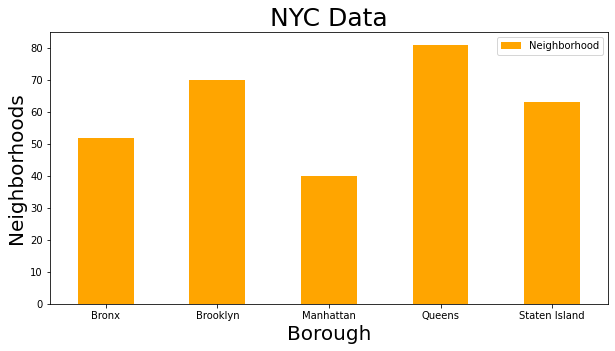

In [8]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="orange")
plt.title('NYC Data', fontsize = 25)
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('Neighborhoods',fontsize = 20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_restaurants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(ny_data),')','Mexican Restaurants in '+Neighborhood+', '+Borough+':'+str(len(mexican_restaurants)))
    print(row)
    for resturant_detail in mexican_restaurants.values.tolist():
        id, name , category=resturant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Mexican Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Mexican Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Mexican Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Mexican Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Mexican Restaurants in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Mexican Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Mexican Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Mexican Restaurants in Norwood, Bronx:1
['

In [10]:
mexican_rest_ny.to_csv('mexican_rest_ny.csv')

mexican_nyc = pd.read_csv('mexican_rest_ny.csv')
mexican_rest_ny.tail()

,Borough,Neighborhood,ID,Name
119,Brooklyn,Dumbo,4f69f2b76d86f87117bb13ab,Gran Eléctrica
120,Brooklyn,Homecrest,507e08fae4b0998ce3421276,El Mexicano Restaurante & Cafe Inc
121,Brooklyn,Homecrest,4a3ada26f964a5205fa01fe3,La Villita Mexican Restaurant
122,Bronx,Kingsbridge Heights,4b403740f964a520e8b625e3,Montezuma Mexican Restaurant
123,Bronx,Kingsbridge Heights,4e4c9e1318388d49816b44d8,La Catrina


In [11]:
mexican_rest_ny.shape

(124, 4)

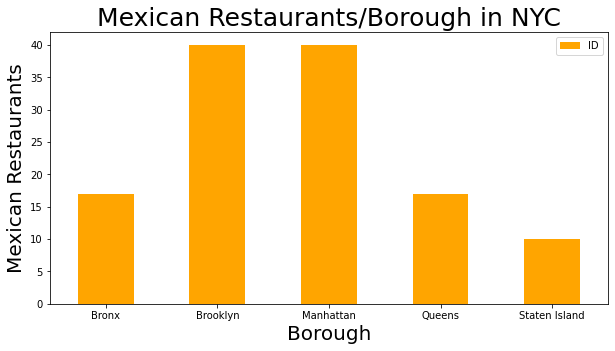

In [12]:
mexican_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color="orange")
plt.title('Mexican Restaurants/Borough in NYC', fontsize = 25)
plt.xlabel('Borough', fontsize = 20)
plt.ylabel('Mexican Restaurants', fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

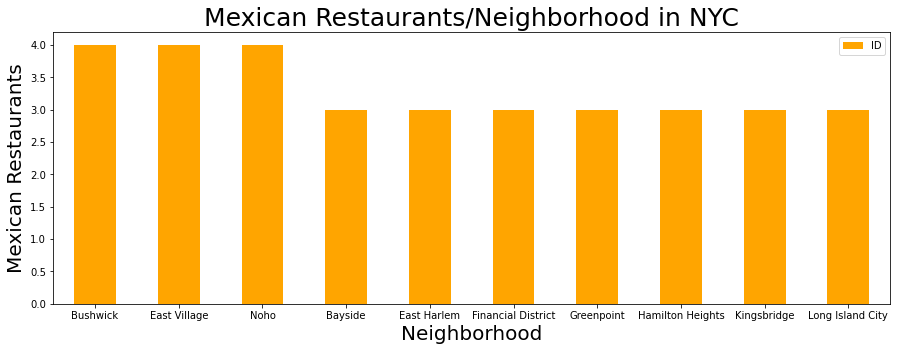

In [13]:
besthoods = 10 # top 10 Neighborhoods
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(besthoods).plot.bar(figsize=(15,5), color="orange")
plt.title('Mexican Restaurants/Neighborhood in NYC', fontsize = 25)
plt.xlabel('Neighborhood', fontsize = 20)
plt.ylabel('Mexican Restaurants', fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Bushwick']

,Borough,Neighborhood,ID,Name
27,Brooklyn,Bushwick,507c9d44e4b07390823b8d98,Taqueria Sofia
28,Brooklyn,Bushwick,54a5a765498e6b7e2ce128c8,El Kucho
29,Brooklyn,Bushwick,4a79c17ef964a52093e71fe3,El Sol de Cholula
30,Brooklyn,Bushwick,4dd6d110814d85e931ff48e4,Zefe's Mexican Restaurant


In [15]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='East Village']

,Borough,Neighborhood,ID,Name
67,Manhattan,East Village,5209469f11d2d4f85e5b7427,Tacos Cuautla Morelos
68,Manhattan,East Village,49e80026f964a52037651fe3,Zaragoza Mexican Deli-Grocery
69,Manhattan,East Village,4d322023c75a6ea8cc220bae,El Camion Cantina
70,Manhattan,East Village,544153df498e8f7dae118d8e,Empellón Al Pastor


In [17]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Noho']

,Borough,Neighborhood,ID,Name
105,Manhattan,Noho,518ae551498e2f46f121c613,El Diablito Taqueria
106,Manhattan,Noho,553ac3c8498e6d2422de7741,Rosie's
107,Manhattan,Noho,4bb270a8a32876b0d39900fe,Downtown Bakery
108,Manhattan,Noho,536da20a498e8a08809d145a,Essex Taqueria


In [18]:
mexican_rest_ny[mexican_rest_ny['Neighborhood']=='Bayside']

,Borough,Neighborhood,ID,Name
89,Queens,Bayside,4babe1e3f964a520e6d13ae3,Cinco De Mayo
90,Queens,Bayside,4b5a51ddf964a520e7bc28e3,Tequila Sunrise
91,Queens,Bayside,5ba7f851772fbc003913161b,Spanglish NYC


Manhattan & Brooklyn has 40 restaurants, then in tie for third place is Queens with Bronx with more than 15. these are the top 3 Boroughs. 
Bushwick, East Village and Noho are the ones with more restaurants (4) in the neighborhoods, so although Manhattan and Brooklyn are tied with 40 Restaurants each, since Noho & East Village are from Manhattan, Manhattan would be the best Borough for opening a new Mexican Reastaurant. 

In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_stats_nyc=pd.DataFrame(columns=column_names)
count=1
for row in mexican_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_rest_ny),')','processed')
    mexican_stats_nyc =  mexican_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
mexican_stats_nyc.tail()

{'meta': {'code': 200, 'requestId': '600da4ce0d13d94ee138eca4'}, 'response': {'venue': {'id': '5217dd2811d2d06ccafb77d3', 'name': 'Estrellita Poblana V', 'contact': {'phone': '7188843825', 'formattedPhone': '(718) 884-3825'}, 'location': {'address': '240 W 231st St', 'lat': 40.879687039717524, 'lng': -73.906256832975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879687039717524, 'lng': -73.906256832975}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estrellita-poblana-v/5217dd2811d2d06ccafb77d3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://www.estrel

KeyError: 'venue'

In [20]:
mexican_stats_nyc.to_csv('mexican_stats_ny.csv') 

In [21]:
mexican_stats_nyc.shape

(50, 7)

I only manage to get 50 due to Foursquare limited calls per day.

In [22]:
mexican_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [23]:
mexican_stats_nyc['Likes'] = mexican_stats_nyc['Likes'].astype('float64')
mexican_stats_nyc['Tips'] = mexican_stats_nyc['Tips'].astype('float64')
mexican_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [24]:
mexican_stats_nyc.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,48.040000,7.174000,19.680000
std,60.432104,1.980086,23.054895
min,0.000000,0.000000,0.000000
25%,9.250000,6.825000,3.000000
50%,24.000000,7.600000,8.000000
75%,54.000000,8.100000,35.250000
max,250.000000,9.100000,88.000000


We are going to look for Restaurants with max likes, max ratings and max tips, this will be limited due to foursquare limitation of data but my analysis will be subjecrted to these 50 ratings.'\

In [26]:
# Restaurant with maximum Likes
mexican_stats_nyc.iloc[mexican_stats_nyc['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              5ae8ed8eb3c961002b3360da
Name                             Oxomoco
Likes                                250
Rating                                 9
Tips                                  54
Name: 17, dtype: object

In [27]:
# Restaurant with maximum Ratings
mexican_stats_nyc.iloc[mexican_stats_nyc['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                 Parkchester
ID              4b4929d2f964a520656826e3
Name                   Taqueria Tlaxcali
Likes                                131
Rating                               9.1
Tips                                  73
Name: 7, dtype: object

In [28]:
# Restaurant with maximum Tips
mexican_stats_nyc.iloc[mexican_stats_nyc['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                  South Side
ID              430d0a00f964a5203d271fe3
Name                          Taco Chulo
Likes                                209
Rating                               7.9
Tips                                  88
Name: 46, dtype: object

In [29]:
nyc_nh_stats=mexican_stats_nyc.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
nyc_nh_stats.columns=['Neighborhood','Average Rating']
nyc_nh_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
22,Parkchester,9.100000
5,Chinatown,8.650000
18,North Side,8.400000
28,Westchester Square,8.050000
23,Prospect Heights,8.033333
26,South Side,8.000000
3,Brooklyn Heights,7.950000
4,Bushwick,7.900000
27,Sunset Park,7.850000
15,Kingsbridge,7.833333


In [30]:
nyc_b_stats=mexican_stats_nyc.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
nyc_b_stats.columns=['Borough','Average Rating']
nyc_b_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.650000
1,Brooklyn,7.364706
0,Bronx,6.500000


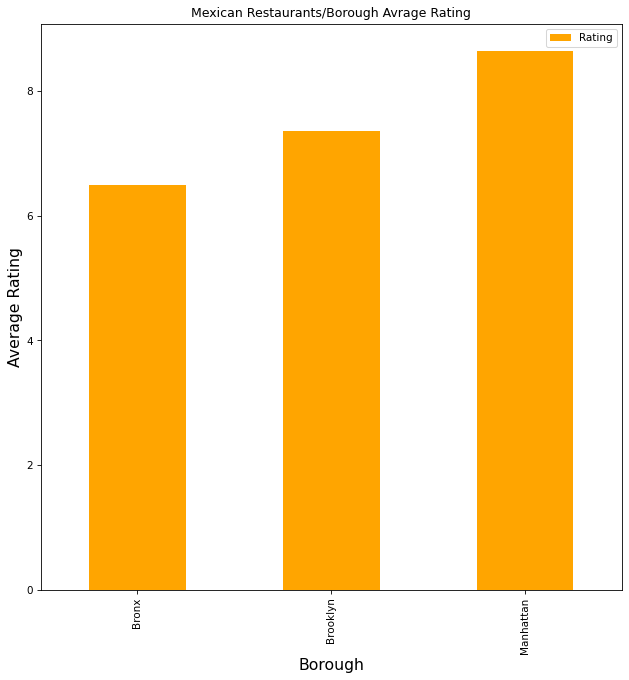

In [52]:
plt.figure(figsize=(10,10), dpi = 75)
plt.title('Mexican Restaurants/Borough Avrage Rating')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
mexican_stats_nyc.groupby('Borough').mean()['Rating'].plot(kind='bar', color='Orange')
plt.legend()
plt.show()

this confirms previous analysis that Manhattan would be the best place for opening a new Mexican Restaurant, & Brooklyn second place based on only these limited ratings. Since we only have 3 Bouroughs we will visualize all in the map.

In [38]:
nyc_nh_stats=nyc_nh_stats[nyc_nh_stats['Average Rating']>=6.0]
nyc_nh_stats

,Neighborhood,Average Rating
0,Bay Ridge,6.700000
1,Bedford Park,7.100000
2,Belmont,7.300000
3,Brooklyn Heights,7.950000
4,Bushwick,7.900000
5,Chinatown,8.650000
6,Clinton Hill,7.200000
7,Downtown,7.100000
8,East Williamsburg,6.750000
9,Flatbush,7.400000


In [39]:
# We'll get lon and lat values
nyc_nh_stats=pd.merge(nyc_nh_stats,ny_data, on='Neighborhood')
nyc_nh_stats=nyc_nh_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
nyc_nh_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,6.700000
1,Bronx,Bedford Park,40.870185,-73.885512,7.100000
2,Bronx,Belmont,40.857277,-73.888452,7.300000
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.950000
4,Brooklyn,Bushwick,40.698116,-73.925258,7.900000
5,Manhattan,Chinatown,40.715618,-73.994279,8.650000
6,Brooklyn,Clinton Hill,40.693229,-73.967843,7.200000
7,Brooklyn,Downtown,40.690844,-73.983463,7.100000
8,Brooklyn,East Williamsburg,40.708492,-73.938858,6.750000
9,Brooklyn,Flatbush,40.636326,-73.958401,7.400000


In [46]:
nyc_map = folium.Map(location=geo_location('New York'), zoom_start=11)
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in nyc_nh_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            color='black',
            fill=True,
            fill_color='orange',
            fill_opacity=0.8
        )
    )

nyc_nh_stats['Label']=nyc_nh_stats['Neighborhood']+', '+nyc_nh_stats['Borough']+'('+nyc_nh_stats['Average Rating'].map(str)+')'

for lat, lng, label in nyc_nh_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map)        

nyc_map.add_child(rating)

Added pop-up text & ratings


## Conclusion

Although Queens has the most neighborhoods Manhattan and Brooklyn managed to have the most Mexican Restaurants with a total of 40 each. Based only on this information we can say that Manhattan and Brooklyn should be our place to open a new restaurant. Doing more research, in tie for third place is Queens & Bronx with more than 15. These Boroughs will be the "top 3" options. As for the neighborhoods we have that Bushwick, East Village and Noho are the ones with more restaurants (4), so although Manhattan and Brooklyn are tied with 40 Restaurants each, since Noho & East Village are from Manhattan, Manhattan would be the best Borough for opening a new Mexican Restaurant based on this information. 

Further analysis leads us that Manhattan has the best Average rating for Mexican restaurants, second place Brooklyn and third place the Bronx, I must note that this last information was limited to only 50 ratings from 306 restaurants, it is a very small sample from the total restaurants but due to Foursquare limited calls these is the most information I can gather with a free account.

With that said, some valuable information that we need to note here is that although Manhattan is always in first place based in these data, the restaurants with the most likes and best tips are the ones from Brooklyn, and as a matter of fact the BEST Mexican restaurant was rated with 9.1 and this restaurant was from the Bronx, who is in third place on average. & that would be the place to have the best Mexican food, the place is called “Taqueria Tlaxcali” I'm guessing you will have the best tacos in NYC. 

Based only on these data we can conclude that Manhattan should be the best choice for opening a restaurant, further analysis needs to be done in order to get the whole data and make a better decision for the investor.